# Measurements in objects in tiled images
For some specific image analysis tasks it might be possible to overcome limitations such as when applying connected component labeling. 

For example, when measuring the size of objects and if these objects are limited in size, it is not necessary to combine intermediate image processing results in big images.
We could just measure object properties for all objects in tiles and then combine the result of the quantification.

In [1]:
import numpy as np
import dask
import dask.array as da
from skimage.data import cells3d
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow

Our starting point is again a binary image showing segmented objects.

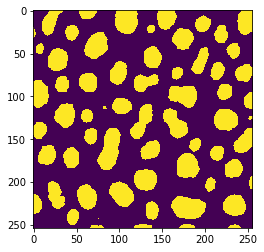

In [2]:
image = imread("../../data/blobs.tif") > 128
imshow(image)

This time, we would like to measure the size of the objects and visualize that in a parametric image. For demonstration purposes, we execute that operation first on the whole example image.

In [3]:
def area_map(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    labels = cle.connected_components_labeling_box(image)
    result = cle.pixel_count_map(labels)
    
    return np.asarray(result)
    

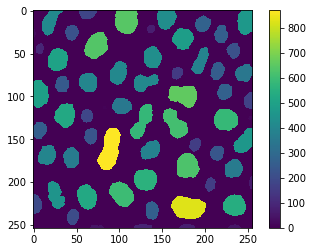

In [4]:
reference = area_map(image)

cle.imshow(reference, colorbar=True)

If we process the same in tiles, we will get slightly wrong results because of the tiled connected-component-labeling issue demonstated earlier.

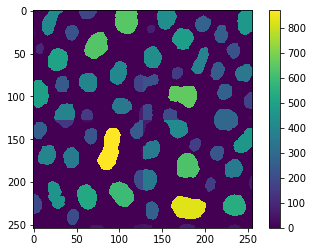

In [5]:
# tile the image
tiles = da.from_array(image, chunks=(128, 128))

# setup the operation we want to apply
procedure = area_map

# setup the tiling
tile_map = da.map_blocks(procedure, tiles)

# compute result
result = tile_map.compute()

# visualize
imshow(result, colorbar=True)

Again, the errors are visible at the border and we can visualize that by direct comparison:

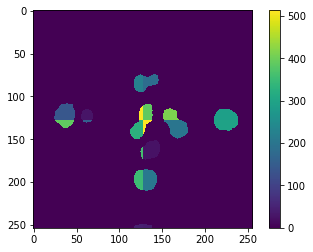

In [6]:
absolute_error = cle.absolute_difference(result, reference)

cle.imshow(absolute_error, colorbar=True)

To prevent this error, we need to think again about processing the image tiles with an overlap. In this particular example, we are not executing any operation that takes neighboring pixels into account. Hence, we cannot estimate the necessary overlap from such parameters. We need to take the maximum size (diameter) of the objects into account. We could also do this emprically, as before. Therefore, let's compute the mean squared error, first of the two example results above:

In [7]:
cle.mean_squared_error(result, reference)

4338.783956692913

And next, we can compute that error in a loop varying the overlap using [dask.array.map_overlay](https://docs.dask.org/en/stable/array-overlap.html) size while processing the image in tiles. Note that we're setting `boundary=0` here, because otherwise objects would extend in the binary image and size measurements would be wrong.

In [8]:
for overlap_width in range(0, 30, 5):
    print("Overlap width", overlap_width)
    tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary=0)
    result = tile_map.compute()
    print("mean squared error", cle.mean_squared_error(result, reference))
    print("-----------------------------------")

Overlap width 0
mean squared error 4338.783956692913
-----------------------------------
Overlap width 5
mean squared error 1702.8293553149606
-----------------------------------
Overlap width 10
mean squared error 460.85811392716533
-----------------------------------
Overlap width 15
mean squared error 70.78670952263779
-----------------------------------
Overlap width 20
mean squared error 1.2793891486220472
-----------------------------------
Overlap width 25
mean squared error 0.0
-----------------------------------


The empirically determined overlap where this error becomes 0 is an optimistic estimation. When using this method in you example, make sure you apply a overlap that's larger than the determined value. 

**Note:** The `compute` and `imshow` functions may not work on big datasets as the images may not fit in computer memory. We are using it here for demonstration purposes.

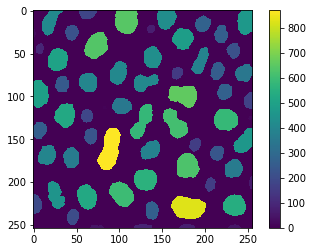

In [9]:
overlap_width = 30

tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary=0)
result = tile_map.compute()

cle.imshow(tile_map, colorbar=True)